# SmartHome Incident Severity Prediction using Machine Learning

Import of libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

1. Descriptive data analysis

The data used in this project comes from the public database of the NVD (National Vulnerability Database). Each entry corresponds to a vulnerability referenced by a unique CVE identifier. The available information is heterogeneous: textual description of the vulnerability, contextual metadata, external links, tags, publication dates, as well as different impact scores (CVSS). The distribution of the target variable (severity) is unbalanced, with a majority of vulnerabilities classified as MEDIUM and HIGH, while the LOW and CRITICAL classes are significantly less represented. This statistical imbalance is common in cybersecurity datasets and will have a significant impact on the performance of supervised models, requiring specific adjustment techniques. This first descriptive step allows identifying the nature of variables, their format, as well as the structural constraints of the dataset before any automatic processing.

Importing the dataset after filtering

In [3]:

file_path = "data_iot.json"

with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)
 
vulns = data.get("vulnerabilities", [])
print(f" Loaded {len(vulns):,} IoT vulnerability entries from file.")
 
df = pd.json_normalize(vulns)
 
print(f" DataFrame created: {df.shape[0]:,} rows and {df.shape[1]} columns")
 
df.head(3)

 Loaded 8,833 IoT vulnerability entries from file.
 DataFrame created: 8,833 rows and 22 columns


,cve.id,cve.sourceIdentifier,cve.published,cve.lastModified,cve.vulnStatus,cve.cveTags,cve.descriptions,cve.metrics.cvssMetricV2,cve.weaknesses,cve.configurations,...,cve.vendorComments,cve.evaluatorSolution,cve.evaluatorComment,cve.evaluatorImpact,cve.cisaExploitAdd,cve.cisaActionDue,cve.cisaRequiredAction,cve.cisaVulnerabilityName,cve.metrics.cvssMetricV30,cve.metrics.cvssMetricV40
0,CVE-1999-0257,cve@mitre.org,1998-04-01T05:00:00.000,2025-04-03T01:03:51.193,Deferred,[],"[{'lang': 'en', 'value': 'Nestea variation of ...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CVE-1999-1499,cve@mitre.org,1998-04-10T04:00:00.000,2025-04-03T01:03:51.193,Deferred,[],"[{'lang': 'en', 'value': 'named in ISC BIND 4....","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CVE-1999-1292,cve@mitre.org,1998-09-01T04:00:00.000,2025-04-03T01:03:51.193,Deferred,[],"[{'lang': 'en', 'value': 'Buffer overflow in w...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'source': 'nvd@nist.gov', 'type': 'Primary',...","[{'nodes': [{'operator': 'OR', 'negate': False...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data extraction and preprocessing

The raw CVE dataset contains nested JSON structures and multiple schema versions.
Before modeling, we extract and standardize the relevant information needed for text classification.

First, we verify the available columns in the dataset to handle possible schema variations.
Then, we extract the English description of each vulnerability.

Finally, we robustly retrieve CVSS information from different schema formats (CVSS v3.1, v3.0, and v2).
When CVSS v3 data is not available, the severity level is inferred from the CVSS v2 base score.
This step ensures a consistent severity label across all records and allows the construction of the target variable used for classification.


In [4]:
# 1) sanity check: see what we actually have
print(sorted(df.columns.tolist())[:50])   # confirm 'metrics' vs 'impact' vs 'cve.metrics'

# 2) description (unchanged)
def get_en(desc):
    if isinstance(desc, (list, tuple)):
        for d in desc:
            if isinstance(d, dict) and d.get("lang") == "en":
                return d.get("value")
    return np.nan

df["description_en"] = df["cve.descriptions"].apply(get_en)

# 3) robust CVSS extractor with fallbacks
def extract_cvss_fields(row):
    # pick the column that exists
    metrics_obj = None
    for col in ("metrics", "cve.metrics", "impact"):
        if col in row and pd.notna(row[col]):
            metrics_obj = row[col]
            break

    sev = np.nan
    score3 = np.nan
    score2 = np.nan

    # NVD 2.0 style: metrics is a dict with lists cvssMetricV31 / V30 / V2
    if isinstance(metrics_obj, dict):
        for k in ("cvssMetricV31", "cvssMetricV30"):
            lst = metrics_obj.get(k)
            if isinstance(lst, list) and lst:
                data = (lst[0] or {}).get("cvssData", {})
                sev = data.get("baseSeverity", sev)
                score3 = data.get("baseScore", score3)
                break
        # try v2 if v3 not present
        if pd.isna(score3):
            lst2 = metrics_obj.get("cvssMetricV2")
            if isinstance(lst2, list) and lst2:
                data2 = (lst2[0] or {}).get("cvssData", {})
                score2 = data2.get("baseScore", score2)

    # Older schema: 'impact' with 'baseMetricV2'
    if pd.isna(score3) and isinstance(metrics_obj, dict):
        bm2 = metrics_obj.get("baseMetricV2")  # older JSON
        if isinstance(bm2, dict):
            cv2 = bm2.get("cvssV2", {})
            score2 = cv2.get("baseScore", score2)

    # derive severity from v2 if v3 missing
    if pd.isna(sev):
        if pd.notna(score2):
            s = float(score2)
            if s < 4.0: sev = "LOW"
            elif s < 7.0: sev = "MEDIUM"
            elif s < 9.0: sev = "HIGH"
            else: sev = "CRITICAL"

    return pd.Series({"cvss3_score": score3, "cvss2_score": score2, "severity": sev})

df[["cvss3_score", "cvss2_score", "severity"]] = df.apply(extract_cvss_fields, axis=1)

# Keep what you need
out = df[["cve.id", "description_en", "severity", "cvss3_score", "cvss2_score", "cve.published", "cve.lastModified"]]
print(out.head())

['cve.cisaActionDue', 'cve.cisaExploitAdd', 'cve.cisaRequiredAction', 'cve.cisaVulnerabilityName', 'cve.configurations', 'cve.cveTags', 'cve.descriptions', 'cve.evaluatorComment', 'cve.evaluatorImpact', 'cve.evaluatorSolution', 'cve.id', 'cve.lastModified', 'cve.metrics.cvssMetricV2', 'cve.metrics.cvssMetricV30', 'cve.metrics.cvssMetricV31', 'cve.metrics.cvssMetricV40', 'cve.published', 'cve.references', 'cve.sourceIdentifier', 'cve.vendorComments', 'cve.vulnStatus', 'cve.weaknesses']
          cve.id                                     description_en  severity  \
0  CVE-1999-0257  Nestea variation of teardrop IP fragmentation ...       NaN   
1  CVE-1999-1499  named in ISC BIND 4.9 and 8.1 allows local use...       NaN   
2  CVE-1999-1292  Buffer overflow in web administration feature ...       NaN   
3  CVE-1999-0911  Buffer overflow in ProFTPD, wu-ftpd, and berof...       NaN   
4  CVE-1999-1513  Management information base (MIB) for a 3Com S...       NaN   

   cvss3_score  cvss2_s

In [5]:
def extract_cvss(row):

    # CVSS v3.1
    m31 = row.get("cve.metrics.cvssMetricV31")
    if isinstance(m31, list) and len(m31)>0:
        d = m31[0].get("cvssData", {})
        sev = d.get("baseSeverity")
        score3 = d.get("baseScore")
        return sev, score3, np.nan
    
    # CVSS v3.0
    m30 = row.get("cve.metrics.cvssMetricV30")
    if isinstance(m30, list) and len(m30)>0:
        d = m30[0].get("cvssData", {})
        sev = d.get("baseSeverity")
        score3 = d.get("baseScore")
        return sev, score3, np.nan
    
    # CVSS v2 fallback
    m2 = row.get("cve.metrics.cvssMetricV2")
    if isinstance(m2, list) and len(m2)>0:
        d = m2[0].get("cvssData", {})
        score2 = d.get("baseScore")
        if score2 is not None:
            # convertir score en niveau
            if score2 < 4: sev="LOW"
            elif score2 < 7: sev="MEDIUM"
            elif score2 < 9: sev="HIGH"
            else: sev="CRITICAL"
            return sev, np.nan, score2
    
    return np.nan, np.nan, np.nan

df[["severity","cvss3_score","cvss2_score"]] = df.apply(lambda r: pd.Series(extract_cvss(r)), axis=1)


## Dataset final selection and cleaning

After extracting the relevant fields, we build the final dataset used for modeling.
We keep only the necessary attributes, including the English description, severity label, CVSS scores, and timestamps.

Records with missing descriptions or missing severity labels are removed to ensure data quality.
The resulting cleaned dataset is then used for exploratory analysis and machine learning experiments.


In [6]:
df_final = df[ ["cve.id","description_en","severity","cvss3_score","cvss2_score","cve.published","cve.lastModified"] ]
df_final = df_final.dropna(subset=["description_en","severity"]).reset_index(drop=True)

df_final.head()

,cve.id,description_en,severity,cvss3_score,cvss2_score,cve.published,cve.lastModified
0,CVE-1999-0257,Nestea variation of teardrop IP fragmentation ...,MEDIUM,NaN,5.0,1998-04-01T05:00:00.000,2025-04-03T01:03:51.193
1,CVE-1999-1499,named in ISC BIND 4.9 and 8.1 allows local use...,LOW,NaN,2.1,1998-04-10T04:00:00.000,2025-04-03T01:03:51.193
2,CVE-1999-1292,Buffer overflow in web administration feature ...,HIGH,NaN,7.5,1998-09-01T04:00:00.000,2025-04-03T01:03:51.193
3,CVE-1999-0911,"Buffer overflow in ProFTPD, wu-ftpd, and berof...",CRITICAL,NaN,10.0,1999-08-27T04:00:00.000,2025-04-03T01:03:51.193
4,CVE-1999-1513,Management information base (MIB) for a 3Com S...,HIGH,NaN,7.5,1999-08-30T04:00:00.000,2025-04-03T01:03:51.193


We have retrieved the CVE data in JSON format from the NVD. The descriptions of vulnerabilities being available in several languages, we systematically extracted the English version (description_en). The target to be predicted (output variable) was constructed from the available CVSS metrics (cvssMetricV31, cvssMetricV30 or cvssMetricV2 in fallback). Severity levels were normalized according to the official NVD values: {LOW, MEDIUM, HIGH, CRITICAL}. After cleaning the irrelevant fields, we obtain a final dataset containing: the CVE identifier, the description in English, the severity as well as the creation and update dates.

3. Formalization of the problem

The problem studied in this work is formulated as a supervised classification task applied to the field of NLP (Natural Language Processing). The objective is to automatically predict the severity level of a vulnerability from its textual description in English. The chosen severity corresponds to the level derived from the CVSS scores provided by the NVD, standardized in four classes: LOW, MEDIUM, HIGH and CRITICAL. The model input is therefore a descriptive plain text, and the expected output is a discrete class reflecting the importance of vulnerability. This type of formalization allows to evaluate the ability of a model to understand the semantic content of a vulnerability and to automatically reproduce an expert impact judgment.

## Dataset analysis (EDA)

We first analyze the dataset at a high level: number of samples, number of classes, class distribution, and basic text statistics (length in characters and words). This helps us detect imbalance and understand the data complexity.


In [11]:

X = df_final["description_en"]
y = df_final["severity"]

# X: list/Series of texts, y: labels (already split or full dataset)
X_series = pd.Series(X, name="text")
y_series = pd.Series(y, name="label")

print("Number of samples:", len(X_series))
print("Number of classes:", y_series.nunique())

# Class distribution
class_counts = y_series.value_counts()
print("\nClass distribution:\n", class_counts)
print("\nClass distribution (%):\n", (class_counts / len(y_series) * 100).round(2))

# Basic text statistics
text_len_chars = X_series.str.len()
text_len_words = X_series.str.split().apply(len)

print("\nText length (chars) - mean:", text_len_chars.mean().round(2), "median:", text_len_chars.median())
print("Text length (words) - mean:", text_len_words.mean().round(2), "median:", text_len_words.median())


Number of samples: 8659
Number of classes: 4

Class distribution:
 label
HIGH        3466
MEDIUM      3331
CRITICAL    1541
LOW          321
Name: count, dtype: int64

Class distribution (%):
 label
HIGH        40.03
MEDIUM      38.47
CRITICAL    17.80
LOW          3.71
Name: count, dtype: float64

Text length (chars) - mean: 418.8 median: 297.0
Text length (words) - mean: 58.26 median: 43.0


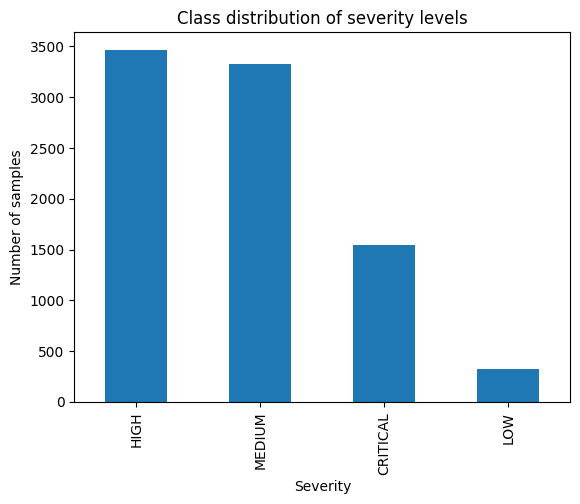

In [12]:
class_counts = df_final["severity"].value_counts()

class_counts.plot(kind="bar")
plt.title("Class distribution of severity levels")
plt.xlabel("Severity")
plt.ylabel("Number of samples")
plt.show()

The class distribution reveals potential imbalance between severity levels, which motivates the use of Macro F1-score as an evaluation metric.


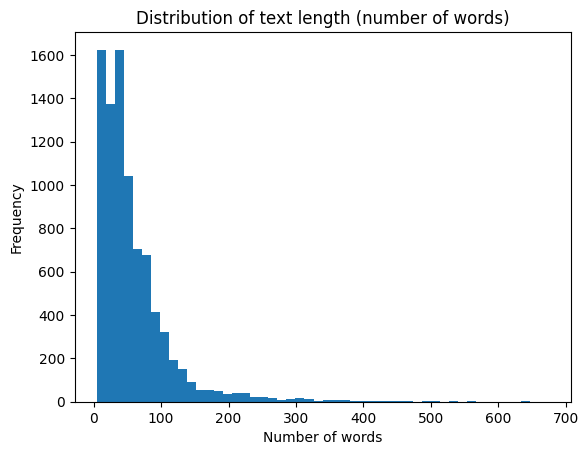

In [13]:
text_lengths = df_final["description_en"].str.split().apply(len)

plt.hist(text_lengths, bins=50)
plt.title("Distribution of text length (number of words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

The variability in text length highlights the heterogeneous nature of vulnerability descriptions and supports the use of TF-IDF representations.


## Baseline model training and evaluation

The dataset is split into training and test sets using a stratified split in order to preserve the class distribution.
A baseline classification model is then built using a TF-IDF representation of the text combined with a Decision Tree classifier.

The model is trained on the training set and evaluated on the test set.
Performance is assessed using a classification report and a confusion matrix to analyze prediction quality across classes.


In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95)),
    ("clf", DecisionTreeClassifier(max_depth=None, random_state=42))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

    CRITICAL       0.52      0.51      0.52       308
        HIGH       0.59      0.60      0.60       694
         LOW       0.42      0.36      0.39        64
      MEDIUM       0.66      0.66      0.66       666

    accuracy                           0.60      1732
   macro avg       0.55      0.53      0.54      1732
weighted avg       0.60      0.60      0.60      1732

[[158 103   1  46]
 [ 99 418  13 164]
 [  1  20  23  20]
 [ 44 166  18 438]]


4. Selection of a baseline model and implementation of the model

To define a first experimental reference, we selected as baseline model a decision tree. This type of model is particularly suitable for quickly testing hypotheses, as it is simple to interpret, does not require strong statistical hypothesis constraints, and allows to explicitly identify the decision rules learned from the digitally transformed text.

The textual descriptions of the vulnerabilities were vectorized using a TF-IDF representation, making it possible to convert the text into a matrix that can be exploited by the model. After separating the dataset into training and test sets, the DecisionTreeClassifier model was trained on the vectorized data, then evaluated on the severity level prediction task.

This baseline model allows above all to provide a minimal starting point for quantifying the difficulty of the problem and the quality of the textual representation, before introducing more advanced models. Although the decision tree is limited in generalization on complex textual data, it constitutes an important initial benchmark for situating future performances. The results obtained will serve as a comparative reference when evaluating more efficient approaches (optimized linear models, balanced models, then Transformers models).

## Hyperparameter tuning

GridSearchCV is used to optimize both TF-IDF and Decision Tree hyperparameters.
A reduced grid and 3-fold cross-validation are selected to limit computational cost.


In [15]:
param_grid_fast = {
    
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [3,5],
    "tfidf__max_df": [0.95],

    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}

In [16]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid_fast,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur accuracy (CV) :", grid.best_score_)

best_model = grid.best_estimator_

print("Combinaison:", len(list(ParameterGrid(param_grid_fast))))
print("Total fits (cv=5):", len(list(ParameterGrid(param_grid_fast))) * grid.cv)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Meilleurs paramètres : {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'tfidf__max_df': 0.95, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Meilleur accuracy (CV) : 0.5855348635773062
Combinaison: 64
Total fits (cv=5): 192


## Evaluation metrics

We report Accuracy for overall correctness and F1-score (macro) to better account for potential class imbalance. Macro-F1 gives equal importance to each class, which is relevant for multi-class or imbalanced text classification.


In [17]:
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.5831408775981525
Macro-F1: 0.5301269498122665

Classification report:

              precision    recall  f1-score   support

    CRITICAL       0.47      0.49      0.48       308
        HIGH       0.58      0.59      0.58       694
         LOW       0.41      0.41      0.41        64
      MEDIUM       0.66      0.64      0.65       666

    accuracy                           0.58      1732
   macro avg       0.53      0.53      0.53      1732
weighted avg       0.59      0.58      0.58      1732



## Evaluation of the optimized model on the test set

The best model obtained from the hyperparameter tuning phase is evaluated on the independent test set.
This evaluation provides an unbiased estimate of the model’s generalization performance.

We report Accuracy and Macro F1-score and analyze the confusion matrix to better understand class-wise prediction behavior.


Accuracy test: 0.5831408775981525
F1 macro test: 0.5301269498122665


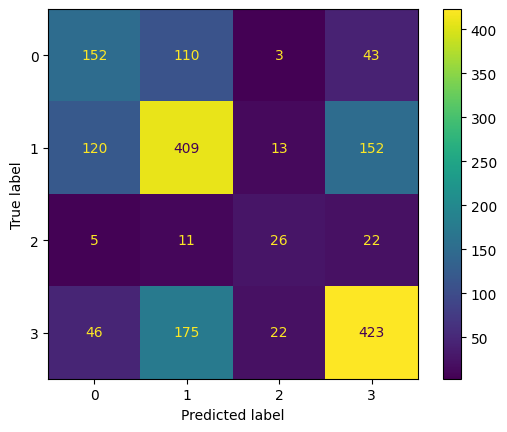

In [18]:

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy test:", accuracy_score(y_test, y_pred))
print("F1 macro test:", f1_score(y_test, y_pred, average="macro"))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [19]:

results = pd.DataFrame(grid.cv_results_)
results.sort_values("rank_test_score").head(10)[
    ["mean_test_score", "std_test_score", "params"]
]

,mean_test_score,std_test_score,params
3,0.585535,0.005821,"{'clf__criterion': 'gini', 'clf__max_depth': N..."
7,0.584236,0.002475,"{'clf__criterion': 'gini', 'clf__max_depth': N..."
15,0.577162,0.005527,"{'clf__criterion': 'gini', 'clf__max_depth': N..."
33,0.576296,0.000408,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
37,0.575574,0.004515,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
35,0.575141,0.005691,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
6,0.574996,0.010587,"{'clf__criterion': 'gini', 'clf__max_depth': N..."
2,0.574996,0.008143,"{'clf__criterion': 'gini', 'clf__max_depth': N..."
36,0.574852,0.009464,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
11,0.573697,0.004248,"{'clf__criterion': 'gini', 'clf__max_depth': N..."


## Dimensionality reduction (LSA)

TF-IDF produces a high-dimensional sparse representation. We test TruncatedSVD (Latent Semantic Analysis) to project TF-IDF vectors into a lower-dimensional space, potentially improving generalization and reducing computation.

In [20]:

svd_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svd", TruncatedSVD(random_state=42)),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid_svd = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_df": [0.95],
    "svd__n_components": [100, 300],   # adjust if needed
    "clf__max_depth": [None, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}

grid_svd = GridSearchCV(
    estimator=svd_model,
    param_grid=param_grid_svd,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid_svd.fit(X_train, y_train)

print("Best params (SVD):", grid_svd.best_params_)
print("Best CV Macro-F1 (SVD):", grid_svd.best_score_)

best_svd_model = grid_svd.best_estimator_


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best params (SVD): {'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'svd__n_components': 100, 'tfidf__max_df': 0.95, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Best CV Macro-F1 (SVD): 0.5122324430526245


## Ensemble models

Ensemble methods require multiple base models in order to combine their predictions.
Therefore, in addition to the optimized Decision Tree, we introduce a second classification model.

The motivation is twofold:
- different models capture different patterns in text data,
- combining complementary models can improve robustness and generalization.

Decision Trees are interpretable but prone to overfitting, while linear models such as Support Vector Machines are known to perform well on high-dimensional text representations.
By combining these models using ensemble techniques, we aim to benefit from their complementary strengths and improve overall performance.


In [21]:

svm_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95)),
    ("svm", LinearSVC())
])

param_grid_svm = {
    "svm__C": [0.1, 1, 10]
}

grid_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print("Best params (SVM):", grid_svm.best_params_)
print("Best CV Macro-F1 (SVM):", grid_svm.best_score_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params (SVM): {'svm__C': 1}
Best CV Macro-F1 (SVM): 0.6100460387507276


### Voting Classifier

The Voting Classifier combines the predictions of multiple base models.
In this project, we use a hard voting strategy, where the final prediction corresponds to the class predicted by the majority of the models.

The objective is to reduce the variance of individual classifiers and improve robustness.
Since the Decision Tree and the SVM rely on different learning principles, their prediction errors are not perfectly correlated, making voting a relevant ensemble approach.


In [22]:
voting = VotingClassifier(
    estimators=[
        ("dt", best_model),
        ("svm", best_svm)
    ],
    voting="hard"
)

voting.fit(X_train, y_train)

y_pred_vote = voting.predict(X_test)
print("Voting Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Voting Macro-F1:", f1_score(y_test, y_pred_vote, average="macro"))


Voting Accuracy: 0.5993071593533488
Voting Macro-F1: 0.558931150662858


### Bagging Classifier

Bagging (Bootstrap Aggregating) aims to reduce model variance by training multiple instances of the same base estimator on different bootstrap samples of the training data.

This approach is particularly well suited for high-variance models such as Decision Trees.
By averaging predictions across multiple trees, Bagging improves stability and generalization without significantly increasing model bias.


In [23]:
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

bag_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95)),
    ("bag", bag_dt)
])

bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)

print("Bagging Accuracy:", accuracy_score(y_test, y_pred_bag))
print("Bagging Macro-F1:", f1_score(y_test, y_pred_bag, average="macro"))


Bagging Accuracy: 0.6443418013856813
Bagging Macro-F1: 0.5961142245477635


## Model comparison and conclusion

We compare baseline and optimized models on an independent test set using Accuracy and Macro-F1. We also discuss computational cost and interpretability. Decision Trees are interpretable but can overfit; SVMs often perform strongly on text classification; ensembles can improve robustness by combining complementary models.


In [24]:
def evaluate(name, model):
    y_pred = model.predict(X_test)
    return {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average="macro")
    }

rows = []
rows.append(evaluate("Decision Tree (best)", best_model))
rows.append(evaluate("SVM (best)", best_svm))
rows.append(evaluate("Voting (DT + SVM)", voting))
rows.append(evaluate("Bagging (DT)", bag_model))

results_df = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
results_df


,model,accuracy,macro_f1
1,SVM (best),0.657044,0.620238
3,Bagging (DT),0.644342,0.596114
2,Voting (DT + SVM),0.599307,0.558931
0,Decision Tree (best),0.583141,0.530127


## Final model performance analysis

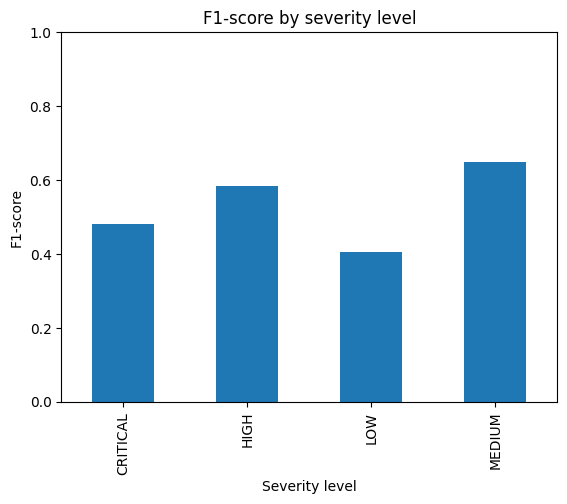

In [25]:
report = classification_report(
    y_test,
    y_pred,
    output_dict=True
)

report_df = pd.DataFrame(report).transpose()

# Keep only severity classes
severity_scores = report_df.loc[
    report_df.index.isin(df_final["severity"].unique()),
    "f1-score"
]

severity_scores.plot(kind="bar")
plt.title("F1-score by severity level")
plt.xlabel("Severity level")
plt.ylabel("F1-score")
plt.ylim(0, 1)
plt.show()

This figure shows the model’s performance across different severity levels.
Higher scores for critical and high severity incidents are particularly important in a Smart Home context, as they correspond to higher security risks.


## Final conclusion

The objective of this project was to predict the severity of security incidents in a Smart Home context based on textual vulnerability descriptions.
To address this problem, we implemented a complete machine learning pipeline including data preprocessing, exploratory analysis, model training, hyperparameter optimization, and evaluation.

The results show that optimized models and ensemble techniques improve classification performance compared to a baseline approach.
This work illustrates how machine learning methods can support risk assessment and decision-making in Smart Home security systems.
